In [92]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [93]:
aval_prices = pd.read_parquet('../data/price_data/processed/aval_processed_data.parquet')
avax1_features = pd.read_parquet('../data/on_chain_data/processed/avax1_chain_processed.parquet')
avax2_features = pd.read_parquet('../data/on_chain_data/processed/avax2_chain_processed.parquet')

common_columns = avax1_features.columns
avax2_features = avax2_features[common_columns]
avax_features = pd.concat([avax1_features, avax2_features], ignore_index=True)

aval_prices['time_close'] = pd.to_datetime(aval_prices['time_close'])
aval_prices.set_index('time_close', inplace=True)
aval_prices.index = pd.to_datetime(aval_prices.index).tz_localize('UTC')
avax_features = pd.concat([avax1_features, avax2_features])

In [94]:
data = avax_features.join(aval_prices[['price_close']], how='inner')

data['price_diff'] = data['price_close'].diff()
threshold = data['price_diff'].std()

def get_signal(diff, threshold):
    if diff > threshold:
        return 'Buy'
    elif diff < -threshold:
        return 'Sell'
    else:
        return 'Hold'

data['Signal'] = data['price_diff'].apply(lambda x: get_signal(x, threshold))
data = data.dropna()

data = data.sort_index()

cutoff = int(len(data) * 0.7)
train_data = data.iloc[:cutoff]
test_data  = data.iloc[cutoff:]

features_train = train_data[['average_gas_limit', 'average_gas_used', 'average_size', 'average_total_difficulty']].values
labels_train = train_data['Signal'].values

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels_train)
y_train = to_categorical(integer_encoded)

scaler = StandardScaler()
X_train = scaler.fit_transform(features_train)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,499 (9.76 KB)

 Trainable params: 2,499 (9.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.1107 - loss: 1.2067 - val_accuracy: 0.0400 - val_loss: 1.0935
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3177 - loss: 1.0844 - val_accuracy: 0.2800 - val_loss: 1.0439
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4974 - loss: 0.9857 - val_accuracy: 0.7200 - val_loss: 0.9996
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5104 - loss: 0.9196 - val_accuracy: 0.7600 - val_loss: 0.9582
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7604 - loss: 0.8249 - val_accuracy: 0.8400 - val_loss: 0.9194
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8464 - loss: 0.7909 - val_accuracy: 0.8400 - val_loss: 0.8830
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8464 - loss: 0.7427 - val_accuracy: 0.8400 - val_loss: 0.8489
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8190 - loss: 0.7555 - val_accuracy: 0.8400 - val_loss: 0.8194

In [95]:
features_test = test_data[['average_gas_limit', 'average_gas_used', 'average_size', 'average_total_difficulty']].values
labels_test   = test_data['Signal'].values

X_test = scaler.transform(features_test)

integer_encoded_test = label_encoder.transform(labels_test)
y_test = to_categorical(integer_encoded_test)

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss: {:.4f}, Test Accuracy: {:.4f}".format(loss, accuracy))

y_pred_test = model.predict(X_test)
positions_test = y_pred_test[:, 0] - y_pred_test[:, 2]

test_data['asset_return'] = test_data['price_close'].pct_change()
test_data = test_data.dropna()

features_test_aligned = test_data[['average_gas_limit', 'average_gas_used', 'average_size', 'average_total_difficulty']].values
X_test_aligned = scaler.transform(features_test_aligned)
y_pred_test_aligned = model.predict(X_test_aligned)
positions_test_aligned = y_pred_test_aligned[:, 0] - y_pred_test_aligned[:, 2]

asset_returns_test = test_data['asset_return'].values.astype(np.float32)

strategy_returns_test = np.roll(positions_test_aligned, shift=1) * asset_returns_test
strategy_returns_test[0] = 0

cumulative_returns_test = np.cumprod(1 + strategy_returns_test) - 1
total_pnl_percentage = cumulative_returns_test[-1]

sharpe_ratio_test = (np.mean(strategy_returns_test) / np.std(strategy_returns_test)) * np.sqrt(365)

initial_capital = 100000
absolute_pnl_test = total_pnl_percentage * initial_capital

print("\nTrading Performance on Test Data (Latter 30%):")
print("Total PnL (percentage): {:.2%}".format(total_pnl_percentage))
print("Absolute PnL: ${:,.2f}".format(absolute_pnl_test))
print("Annualized Sharpe Ratio: {:.4f}".format(sharpe_ratio_test))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8013 - loss: 0.7153
Test Loss: 0.6951, Test Accuracy: 0.8269
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Trading Performance on Test Data (Latter 30%):
Total PnL (percentage): -1.55%
Absolute PnL: $-1,551.94
Annualized Sharpe Ratio: -2.1731


C:\Users\matth\AppData\Local\Temp\ipykernel_4792\476513094.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['asset_return'] = test_data['price_close'].pct_change()


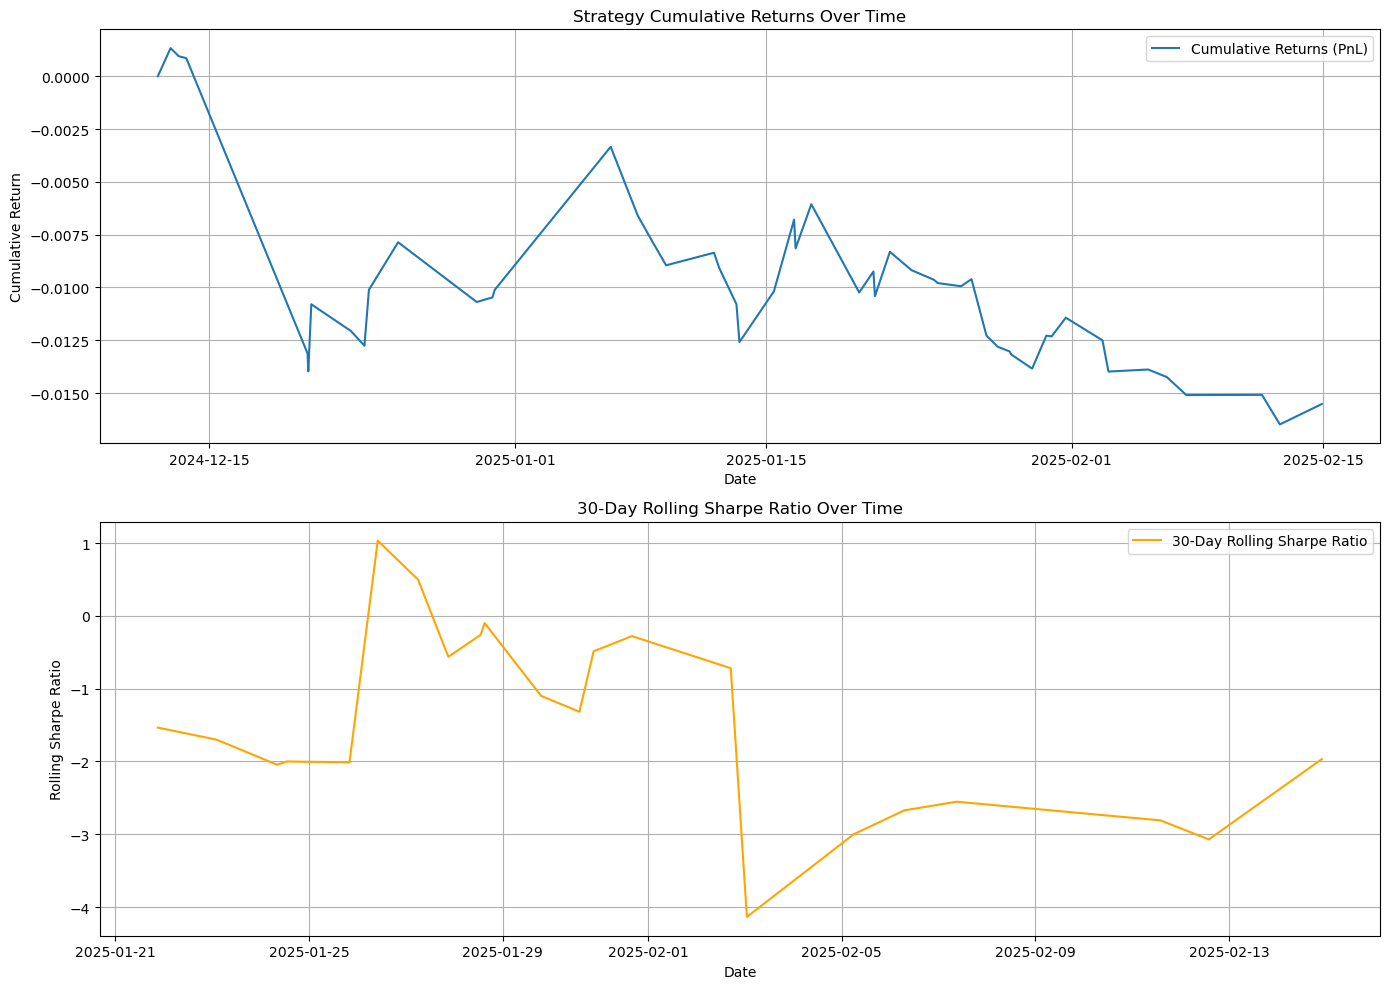

In [96]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assume test_data has a proper DatetimeIndex after dropna()
dates = test_data.index

# Convert cumulative_returns_test (a NumPy array) to a pandas Series with the test dates
cumulative_returns_series = pd.Series(cumulative_returns_test, index=dates)

# Compute a rolling Sharpe ratio on the strategy returns (using a 30-day window as an example)
# We need to build a pandas Series of strategy returns with the same dates:
returns_series = pd.Series(strategy_returns_test, index=dates)

# Define a rolling window (e.g., 30 days)
window = 30

# Calculate rolling Sharpe: (rolling mean / rolling std) * sqrt(365)
# We add a small epsilon to avoid division by zero.
rolling_sharpe = returns_series.rolling(window=window).apply(
    lambda r: (np.mean(r) / np.std(r) * np.sqrt(365)) if np.std(r) != 0 else 0,
    raw=True
)

# Plot cumulative returns and rolling Sharpe ratio
plt.figure(figsize=(14, 10))

# Plot cumulative returns (PnL) over time
plt.subplot(2, 1, 1)
plt.plot(cumulative_returns_series.index, cumulative_returns_series, label='Cumulative Returns (PnL)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Strategy Cumulative Returns Over Time')
plt.legend()
plt.grid(True)

# Plot rolling Sharpe ratio over time
plt.subplot(2, 1, 2)
plt.plot(rolling_sharpe.index, rolling_sharpe, label=f'{window}-Day Rolling Sharpe Ratio', color='orange')
plt.xlabel('Date')
plt.ylabel('Rolling Sharpe Ratio')
plt.title(f'{window}-Day Rolling Sharpe Ratio Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
